# Data analysis with SciAnalysis

last updated: 2023 May

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.

*exp.dict.keys()*: ['analysis', 'corr', 'corrdata', 'data', 'detector', 'exp_protocol', 'expinfo', 'expname', 'folder', 'mdata_list', 'metadata']

--------------------------------------

# &#9635; SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [2]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint, math
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

%pwd

2023/06/27 11:29:33



'/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/data'

## 0. Calibration

__Direct beam (if available)__

['/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/AgBH_cali_13.5kev_openarea/maxs/raw/AgBH_cali_13.5kev_openarea-directbeam_2_1494.8s_RH31.118_x28.138_th1.074_1.00s_961236_maxs.tiff']
Size = (1043, 981)
Beam center = [245, 716]
Beam center = [543, 606]


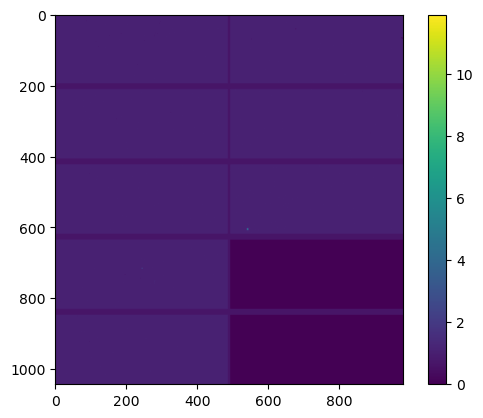

In [2]:
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/saxs/'  
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/AgBH_cali_13.5kev_openarea/maxs/'
pattern = '*directbeam*'
infiles = glob.glob(os.path.join(EXPR_DIR+'raw/', pattern+'.tiff'))
print(infiles)

data = Data2DScattering()
data.load(infiles[0])
#data.blur(sigma=1)
img = data.data
print('Size = {}'.format(img.shape))

## Plot
%matplotlib inline
plt.figure(1); plt.imshow(np.log(img+3)); plt.colorbar()
beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
print('Beam center = {}'.format(beam_center))

img[beam_center[1], beam_center[0]] = 0
beam_center = [np.argmax(np.max(img,0)), np.argmax(np.max(img,1))]
print('Beam center = {}'.format(beam_center))

__Calibration: Energy, beam center, SD distance__

1. Specify wavelength 
2. Tweak beam center and SD distance to get the best match for the calibrant


Calibration qlist = [0.1076 0.2152 0.3228]



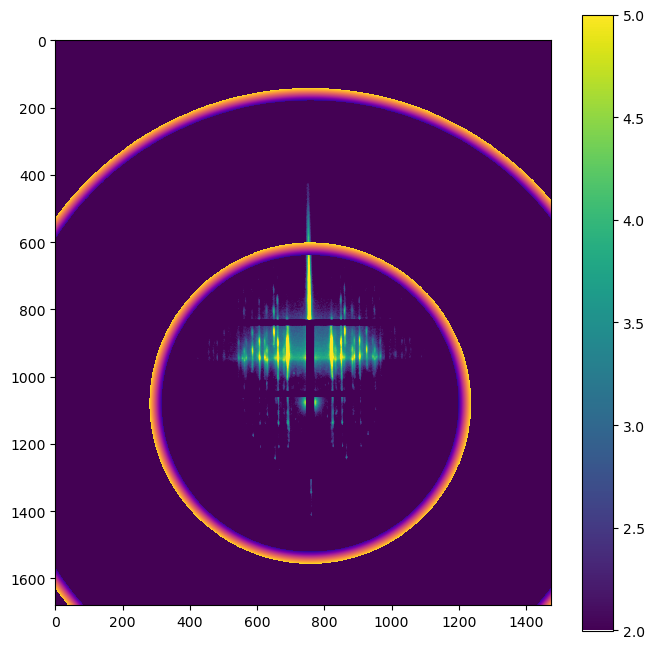

In [3]:
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/AgBH_cali_13.5kev_openarea/'
exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='maxs', beamline=None) ##Experiment name: rbitrary or related to the sample name
pattern = '*Ag*1230*'  


EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/RLi2/' 
exp = Experiment.experiment('B5', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
pattern = '*B5-80*26179*'

        
        
exp.defFiles(fn=pattern, verbose=0)     
infiles = exp.dict['rawinfo']['filename']
Nfiles = len(infiles)
    
if 0: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=0.9184) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    #calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr
    calibration.set_beam_position(543, 606) #LRichter

    #calibration.set_distance(0.259)
    calibration.set_distance(0.2815)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')

else: #SAXS   
    calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
    calibration.set_image_size(1475, height=1679) # Pilatus2M
    calibration.set_pixel_size(pixel_size_um=172.0)

    calibration.set_beam_position(757, 1679-600) # SAXSx -65, SAXSy -73    
    calibration.set_distance(5.02)    

    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    if 1: #flag_stitch
        mask = Mask(mask_dir+'Dectris/Pilatus2M_vertical_gaps-mask.png')
    else:
        mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
    #mask.load(EXPR_DIR+'saxs/analysis/mask_saxs.png')    
    
    
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             }
run_args = { 'verbosity' : 3,
             'AgBH': True, 
             'CeO2': False
           }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

### Analysis 
protocols = ['circular_average'] 
det = exp.dict['expinfo']['det']
folder = exp.dict['expinfo']['folder']
infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][0]+'_'+det+'.tiff'
data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)
line_plot = data.circular_average_q_bin(error=False)


## Plot 2D 
%matplotlib inline
#%matplotlib ipympl

if 1:
    plt.figure(1, figsize=(8,8)); plt.clf()
    plt.imshow(np.log(data.data+3), vmin=2, vmax=5); plt.colorbar() 

    dq = 0.005
    qlist = []
    if 'AgBH' in run_args and run_args['AgBH']:
        q0 = 0.1076
        num_rings = 3
        qlist.extend(q0*np.arange(1,num_rings+1))       
        
    if 'CeO2' in run_args and run_args['CeO2']:
        q0 = (2*np.pi/5.411)*np.sqrt(3)          # A^-1, (111)
        qlist.extend( ( q0/np.sqrt(3) )*np.array((np.sqrt(3), 2, np.sqrt(8),np.sqrt(11),np.sqrt(12),np.sqrt(16),np.sqrt(19),  np.sqrt(20)))  )
    
    qlist.sort();     qlist = np.asarray(qlist)
    print('\nCalibration qlist = {}\n'.format(qlist))    
    
    for q in qlist:
        region = data.calibration.q_map()
        region = np.ma.masked_where(abs(region-q)>dq, region)
        plt.imshow(region, cmap='plasma')

## Plot 1D 
if 0:
    flag_log = 1
    plt.figure(2, figsize=(10,5)); plt.clf()
    q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', roundup=3, verbose=1)  #Tools.rand_color(0.5, 0.8)
    
    y_range = [np.min(line_plot.y), np.max(line_plot.y)]
    qlist[qlist > np.max(line_plot.x)] = None
    Tools.label_peaks(qlist, flag_log=flag_log, y_range = y_range, color='g', verbose=0) 
   

__Convert between q and angle__

In [4]:
print('At {} keV'.format(calibration.get_energy()))
print(data.calibration.q_to_angle(1))
print(data.calibration.angle_to_q(20))

At 13.500018665493208 keV
8.38227707099533
2.376009752908029


## 1. Raw data

In [41]:
### Specify directory, detector, and files of interest
if 0: #SAXS
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/CKe/'
    exp = Experiment.experiment('Ag', folder=EXPR_DIR, det='saxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*Ag*1016533*']  

if 1: #WAXS, temperature
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/'  ##SA
    exp = Experiment.experiment('PBG_run1', folder=EXPR_DIR, det='waxs', beamline='cms') 
    exp.dict['expinfo']['fn_patterns'] = ['*_PBG*run1*x0.0*y0.0*10133*']  #*10133

if 0: #WAXS mapping
    
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/' 
    exp = Experiment.experiment('B6_N3', folder=EXPR_DIR, det='waxs', beamline='cms')
    exp.dict['expinfo']['fn_patterns'] = ['*B6_N3_Trans3_map_vac_x*']  

if 0: #MAXS burstmode (series)
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/LRichter2/MM389_KCl/' 
    exp = Experiment.experiment('MM389_KCl', folder=EXPR_DIR, det='maxs', series_measure=True, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*MM389*run4*']  
      
if 0: 
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/beamline/RLi2/' 
    exp = Experiment.experiment('B5-140-2', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*B5-140-2*x0.0*']  

    exp = Experiment.experiment('B4-170-17', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*B4-170-17*x0.0*']  

    exp = Experiment.experiment('B5-80-5', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*B5-80-5*x0.0*']  

    exp = Experiment.experiment('B5-80-5', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*B5-80-5*x0.0*']  
    # exp = Experiment.experiment('B7', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    # exp.dict['expinfo']['fn_patterns'] = ['*B7-80-3*x1.0*']  

    # exp = Experiment.experiment('B5', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    # exp.dict['expinfo']['fn_patterns'] = ['*B5-80-4*']  
    
    # exp = Experiment.experiment('B5', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    # exp.dict['expinfo']['fn_patterns'] = ['*B5-80-5*']  
    # exp = Experiment.experiment('B5', folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    # exp.dict['expinfo']['fn_patterns'] = ['*B5-140-6*']  
    
if 1: 
    # EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/test4/' 
    samplefolder_load = 'test4' # sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010
    
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/'  + samplefolder_load + '/'
    exp = Experiment.experiment(samplefolder_load, folder=EXPR_DIR, det='maxs', series_measure=True, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = [f'{samplefolder_load}*']  


### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        exp.defFiles(fn=pattern, verbose=1) 
        # exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
        # infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [1116002], verbose=1)  
        # infiles = exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [1116215], verbose=1)  
    
    # infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        exp.defFiles_ScanID_ONLY(fn=pattern, scanid = [1116215], verbose=1)  
    

### Show some info   
exp.show()
exp.showFileInfo(idx=0)


/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/test4/maxs/raw/
Loaded 10 files.
(defFiles time = 0.2s)

=== Overview of experiment dictionary ===
exp.dict['expinfo']
  -  keys = ['expname', 'det', 'beamline', 'folder', 'ext', 'fn_patterns']
  -  key = expname, <class 'str'>, val = test4
  -  key = det, <class 'str'>, val = maxs
  -  key = beamline, <class 'str'>, val = cms
  -  key = folder, <class 'str'>, val = /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/test4/
  -  key = ext, <class 'str'>, val = tiff
  -  key = fn_patterns, <class 'list'>
exp.dict['rawinfo']
  -  keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure', 'num_frames']
  -  key = filename, <class 'list'>, len(shape) = 10
  -  key = time, <class 'list'>, len(shape) = 10
  -  key = clock, <class 'list'>, len(shape) = 10
  -  key = scan_id, <class 'list'>, len(shape) = 10
  -  key = uid, <class 'list'>, len(shape) = 10
  -  key = filenumber, <class 'list'>, len(shape) = 10
  -  key = s

## 2. Metadata

In [12]:
## See metadata for one file
import databroker
cat = databroker.catalog['cms']
scan_id = exp.dict['rawinfo']['scan_id'][0]  #959455
h = cat[scan_id]
h.metadata['start']


Start({'beam_intensity_expected': 8300,
 'calibration_energy_keV': 17.0,
 'calibration_wavelength_A': 0.72932,
 'detectors': ['pilatus2M'],
 'experiment_SAF_number': '30100',
 'experiment_alias_directory': '/GPFS/xf11bm/data/2018_3/OChen2',
 'experiment_cycle': '2018_3',
 'experiment_group': 'O. Chen( Brown U.)',
 'experiment_project': 'high pressure',
 'experiment_proposal_number': '301000',
 'experiment_type': 'GISAXS, GIWAXS',
 'experiment_user': 'various',
 'hints': {'dimensions': [[['time'], 'primary']]},
 'num_intervals': 0,
 'num_points': 1,
 'plan_args': {'detectors': ["Pilatus2MV33(prefix='XF:11BMB-ES{Det:PIL2M}:', "
                             "name='pilatus2M', read_attrs=['stats1', "
                             "'stats1.total', 'stats2', 'stats2.total', "
                             "'stats3', 'stats3.total', 'stats4', "
                             "'stats4.total', 'tiff'], "
                             "configuration_attrs=['cam', 'stats1', 'stats2', "
               

In [13]:
### Check metadata at the beamline, identify md of interest, e.g. sample_temperature_D, sample_x
file_idx = 0
scan_id = exp.dict['rawinfo']['scan_id'][file_idx]
#exp.showMetadata(scanid=scan_id, md_interest=None)
exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'scan_id'])
#exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x', 'sample_y'])

### Scan 1116215:


KeyError: 'sample_clock'

In [14]:
## Options: (1) load metadata from databroker at beamline. (2) load md from h5. (3) Extract info from filename
md_load_option = 1

## Clear all metadata
exp.dict['metadata'] = {}


## Load metadata
if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['scan_id'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    frames = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        
        Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        #sample_x.append(float(temp[-4][1:]))
        #sample_y.append(float(temp[-3][1:]))
        
        #Ts.append(float(infile.split('RH')[1].split('_x')[0]))
        #scan_id.append(int(temp[-1]))
        #frames.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    #exp.dict['metadata']['sample_x'] = np.array(sample_x)
    #exp.dict['metadata']['sample_y'] = np.array(sample_y)
    #exp.dict['metadata']['frames'] = frames
    
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

[0%] 
[8%] 
[17%] 
[25%] 
[33%] 
[41%] 
[50%] 
[58%] 
[66%] 
[74%] 
[83%] 
[91%] 
[99%] 
(loadMetadata time = 1.9s)
dict_keys(['scan_id'])


In [ ]:
exp.show()

In [ ]:
### Save metadata (for offline analysis later on)
if 0:
    h5_path = EXPR_DIR+"/data/"
    h5_file = exp.name+'_metadata.h5'
    dicttoh5(exp.dict['metadata'], h5_path+h5_file)
    print(h5_path+h5_file)


In [ ]:
exp.name

## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

E.g. 3600 files, 1 protocol, saving to exp.dict: 5min

In [10]:
print(infiles[2])

/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/sam1_pbi2_dmf_0p3m_5scfh_Si_40uL_002/maxs/raw/sam1_pbi2_dmf_0p3m_5scfh_Si_40uL_002_2831.5s_x2.002_th0.300_2.00s_1116003_000002_maxs.tiff


In [15]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)




if 1: #WAXS, MAXS
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=12.4/12.7) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    
    calibration.set_beam_position(576, 1043-390) # Pilatus 800k x=450 y=398 works in xi-cam, in scianalysis need y=1043-398=645
    calibration.set_distance(0.3)

    ## LRichter
    if 0:
        calibration.set_beam_position(543, 606) #LRichter
        calibration.set_distance(0.2815)
    
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k2_gaps-mask.png')
    mask.load('./Pilatus800k2_custom-mask.png')

  
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


### Run analysis 
protocols = ['circular_average'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            # infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            infile_fullpath = infile
            # print(infile_fullpath)
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   
            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    if 'linecut_qr' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Run the protocol
            line_output = data.linecut_qr(qz=0.03, dq=0.003)
            line_y_stack.append(line_output.y)

        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack           
        
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

[2%]
[4%]
[6%]
[8%]
[10%]
[12%]
[14%]
[16%]
[19%]
[21%]
[23%]
[25%]
[27%]
[29%]
[31%]
[33%]
[35%]
[37%]
[39%]
[41%]
[43%]
[45%]
[47%]
[50%]
[52%]
[54%]
[56%]
[58%]
[60%]
[62%]
[64%]
[66%]
[68%]
[70%]
[72%]
[74%]
[76%]
[78%]
[80%]
[83%]
[85%]
[87%]
[89%]
[91%]
[93%]
[95%]
[97%]
[99%]
Done! (Analysis took 143s)

2023/06/27 11:38:51

dict_keys(['cali', 'circular_average'])


In [17]:
plt.imshow(exp.dict['analysis'][protocol]['I_stack'] )

In [16]:
plt.plot(line_output.x, line_output.y)

In [ ]:
exp.show()

__Instead of doing analysis, can load previously analyzed data__

In [ ]:
if 0:
    exp.loadSciAnalysisData(keys=['circular_average'], analysis_folder=str(exp.dict['folder'])+'waxs/analysis/PBG_run1/', verbose=1)
    exp.dict['analysis'].keys()

## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [18]:
# h5_path = EXPR_DIR+"/data/"

h5_path = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/'+"/data/"


h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite//data/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_cms_exp.h5


In [15]:
EXPR_DIR

'/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/sam1_pbi2_dmf_0p3m_5scfh_Si_40uL_002/'

In [ ]:
#bash analysis 


samplenames = [ 'B4-170-17', 'B5-80-5', 'B5-80-cut-29', 'B4-80-30', 'B5-140-11','B5-140-2','B7-170-7','B7-170-9','B7-170-16','B7-170-10', 'B7-80-28', 'B7-80-3', 'B7-80-8', 
               'B5-140-6', 'B5-170-10', 'B5-30-14','B5-30-15', 'B5-50-cut-27', 'B5-80-1', 'B5-80-12', 'B5-80-13', 'B5-80-4', 'B5-80-5', 'S1-140-18', 'S1-170-26', 'S2-140-19', 
               'S2-170-20', 'S2-170-23', 'S2-170-24', 'S2-170-25', 'S4-140-22', 'S4-170-21', 'S5-170-24']

for samplename in samplenames:
    exp = Experiment.experiment(samplename, folder=EXPR_DIR, det='saxs', series_measure=False, beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*{}*x0.0*'.format(samplename)]  

    ### Load files
    try:
        for pattern in exp.dict['expinfo']['fn_patterns']:
            #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
            exp.defFiles(fn=pattern, verbose=1) 
            #exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  

        infiles = exp.dict['rawinfo']['filename']
        Nfiles = len(infiles)

    except:
        print('\n!!! Databroker not working, loading files directly.')
        #exp.dict['expinfo']['beamline'] = None
        for pattern in exp.dict['expinfo']['fn_patterns']:
            exp.defFiles(fn=pattern, verbose=1)      


    ### Show some info   
    exp.show()
    exp.showFileInfo(idx=0)


    ## Options: (1) load metadata from databroker at beamline. (2) load md from h5. (3) Extract info from filename
    md_load_option = 1

    ## Clear all metadata
    exp.dict['metadata'] = {}


    ## Load metadata
    if md_load_option==1: # Load md from databroker, this only works at beamline
        exp.dict['mdata_list'] = ['sample_clock', 'scan_id'] # Specify metedata to load
        exp.loadMetadata()
        print(exp.dict['metadata'].keys())

    elif md_load_option==2: # Load md from h5 (previously saved from databroker)
        h5_path = EXPR_DIR+"/data/"
        h5_file = 'B6_N3_metadata.h5'
        exp.dict['metadata'] = h5todict(h5_path+h5_file)


    elif md_load_option==3: ## If databroker md is not available nor saved
        infiles = exp.dict['rawinfo']['filename']
        print('Number of files: {}'.format(len(infiles)))

        Ts = []
        sample_x = []
        sample_y = []
        scan_id = []
        frames = []
        for ii, infile in enumerate(infiles):
            temp = infile.split('_')
            if ii==0: print(temp)

            Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
            #sample_x.append(float(temp[-4][1:]))
            #sample_y.append(float(temp[-3][1:]))

            #Ts.append(float(infile.split('RH')[1].split('_x')[0]))
            #scan_id.append(int(temp[-1]))
            #frames.append(int(temp[-1]))

        exp.dict['metadata']['sample_temperature_D'] = Ts
        #exp.dict['metadata']['sample_x'] = np.array(sample_x)
        #exp.dict['metadata']['sample_y'] = np.array(sample_y)
        #exp.dict['metadata']['frames'] = frames

        print(exp.dict['metadata'].keys())

    else:
        print('No metadata loaded to the exp. dictionary!')

    t0 = time.time()  

    line_y_stack = []
    for protocol in protocols:
        if 'circular_average' in protocol:
            for ii, infile in enumerate(infiles):
                if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

                det = exp.dict['expinfo']['det']
                folder = exp.dict['expinfo']['folder']

                infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
                data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

                ### Run the protocol
                line_output = data.circular_average_q_bin(error=False)
                line_y_stack.append(line_output.y)

                if 0:
                    exp.dict['analysis'][protocol][str(ii)] = {}
                    exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                    exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y

            ### Save analysis to exp.dict
            if 1:
                exp.dict['analysis'][protocol] = {}
                exp.dict['analysis'][protocol]['q'] = line_output.x
                exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   
                #x = Protocols.thumbnails(name=None) 
                #x.run(data, output_dir)

        if 'linecut_qr' in protocol:
            for ii, infile in enumerate(infiles):
                if np.mod(ii+1, 50)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

                det = exp.dict['expinfo']['det']
                folder = exp.dict['expinfo']['folder']

                infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
                data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

                ### Run the protocol
                line_output = data.linecut_qr(qz=0.03, dq=0.003)
                line_y_stack.append(line_output.y)

            ### Save analysis to exp.dict
            if 1:
                exp.dict['analysis'][protocol] = {}
                exp.dict['analysis'][protocol]['q'] = line_output.x
                exp.dict['analysis'][protocol]['I_stack'] = line_y_stack           

        #elif 'sector_average' in protocol: 
        #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

        #elif 'linecut_qz' in protocol:
        #    line_output = data.linecut_qz(qr=0, dq=0.05)

        #elif 'linecut_angle' in protocol:
        #line_output = data.linecut_angle(q0=2.24, dq=0.01)


    print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

    now = datetime.datetime.now()
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
    print("{}\n".format(dt_string))

    print(exp.dict['analysis'].keys())    



    #########save########################
    h5_path = EXPR_DIR+"/data/"
    h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
    output_file = h5_path+h5_file


    ## Check if file exist, will not overwrite
    if False:
        file_exist = os.path.isfile(output_file)
        count = 1
        while file_exist:
            print('{} exists, using a new filename'.format(output_file))
            h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
            output_file = h5_path+h5_file
            file_exist = os.path.isfile(output_file)
            count = count + 1


    ## Save
    dicttoh5(exp.dict, output_file)
    print('Experiment saved as {}'.format(output_file))

    

### __Load H5__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [19]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools




In [22]:
### Load experiment dict (previuosly analyzed data)
if True:
    
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3//data/B6_N3_cms_exp.h5'
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5'
    # exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/data/sam1_pbi2_dmf_cms_exp.h5'
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_2/KWhite/data/sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010_cms_exp.h5'
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

dict_keys(['advanced', 'analysis', 'expinfo', 'mdata_list', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [ ]:
exp.show(verbose=1)

In [24]:
# %matplotlib inline

## 5. Plot

### __(5.1) Data Trend__

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

In [25]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]
print(protocol)
print(exp.dict['rawinfo']['filename'][-1])

## Pick a curve
file_idx = 250
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
flag_log = 1

%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 5, fit_param=[0, 1, 0.001], flag_log=flag_log, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)

q_label = [0.1076]
for q in q_label:
    if flag_log:
        y_range = [0, max(np.log(line_plot.y))]
    else:
        y_range = [min(line_plot.y), max(np.log(line_plot.y))]
    plt.plot([q, q], y_range, 'g',  alpha=0.7)
    plt.text(q, y_range[1]/2, str(q), color='g')


circular_average
sam16_3mai1pbi2_dmf_1m_5scfh_Si_40uL_010*
fit_param = [height, width, prominence]
5 peaks found: [0.2528 1.4008 2.6042 2.6117 2.9401] for fit_prom 0.25024


##### - __Plot all curves as 2D image__

In [26]:
I_stack

array([[3.14270225, 2.8556645 , 2.77204335, ..., 0.98799109, 0.85387196,
        0.97003678],
       [3.11701337, 2.82104164, 2.73410979, ..., 0.89812657, 0.9744459 ,
        0.86530143],
       [3.12192443, 2.82475046, 2.732671  , ..., 0.91764871, 0.95424251,
        0.97003678],
       ...,
       [3.07686285, 2.78501646, 2.70100193, ..., 0.92239514, 0.96781532,
        0.95424251],
       [3.08088692, 2.79490611, 2.70412092, ..., 0.97144454, 0.90308999,
        1.        ],
       [3.07819492, 2.78895985, 2.70645291, ..., 0.85070192, 0.96781532,
        0.90308999]])

In [ ]:
exp.show()

In [ ]:
exp.dict['metadata']

/tmp/ipykernel_248776/3142218644.py:15: RuntimeWarning: divide by zero encountered in log10
  I_stack = np.log10(I_stack)


q_label = [0.2528346  1.40081705 2.60420819 2.61167358 2.94012527]


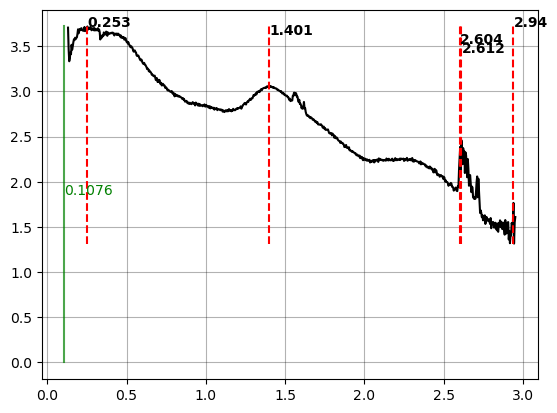

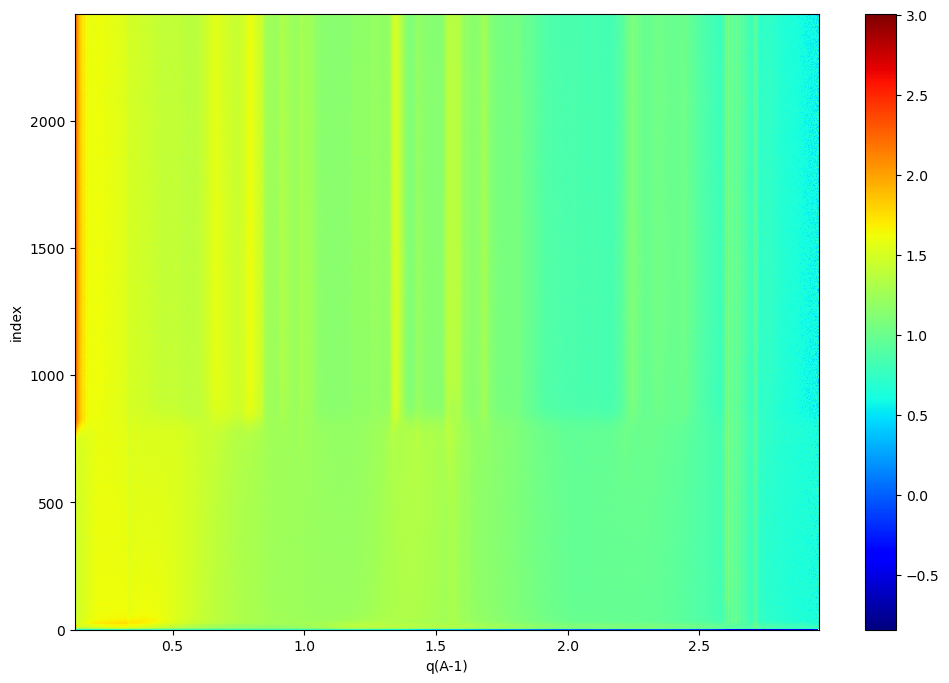

In [26]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
# y_axis = exp.dict['metadata']['scan_id'] - exp.dict['metadata']['scan_id'][0]
# y_axis = exp.dict['metadata']['sample_clock'] #- exp.dict['metadata']['sample_clock'][0]

y_axis = np.arange(len(infiles))
if flag_log:
    I_stack = np.log10(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
# plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), scan_id[0], scan_id[-1]],  aspect='auto') #aspect='auto' 0.005
# # plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
# cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 

# y_axis = np.arange(0, I_stack.shape[0])
X, Y = np.meshgrid(x_axis, y_axis)
#dont know how to change the plotting range in pcolormesh
# plt.pcolormesh(X,Y,I_stack,vmin=.3,vmax=2.8, cmap=mpl.cm.jet); plt.colorbar()
plt.pcolormesh(X,Y,I_stack, cmap=mpl.cm.jet); plt.colorbar()
plt.xlabel('q(A-1)')
plt.ylabel('index')
# plt.ylabel('Time (s)')
# plt.xlim(-.2, .2)
# plt.ylim(0, 2)

print('q_label = {}'.format(q_label))
#for q in q_label:
#    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

/tmp/ipykernel_248776/2720618777.py:15: RuntimeWarning: divide by zero encountered in log10
  I_stack = np.log10(I_stack)


q_label = [0.2528346  1.40081705 2.60420819 2.61167358 2.94012527]


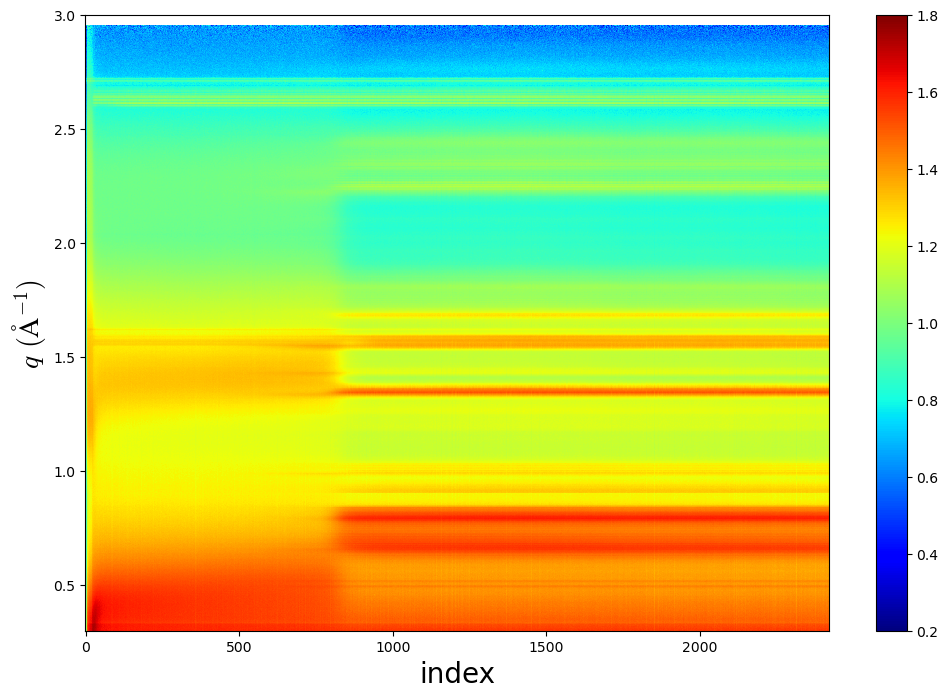

In [37]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[-1]


x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
# y_axis = exp.dict['metadata']['scan_id'] - exp.dict['metadata']['scan_id'][0]
# y_axis = exp.dict['metadata']['sample_clock'] #- exp.dict['metadata']['sample_clock'][0]

y_axis = np.arange(len(infiles))
if flag_log:
    I_stack = np.log10(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
# plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), scan_id[0], scan_id[-1]],  aspect='auto') #aspect='auto' 0.005
# # plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[0]],  aspect='auto') #aspect='auto' 0.005
# cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 

# y_axis = np.arange(0, I_stack.shape[0])
X, Y = np.meshgrid( y_axis, x_axis)
#dont know how to change the plotting range in pcolormesh
# plt.pcolormesh(X,Y,I_stack,vmin=.3,vmax=2.8, cmap=mpl.cm.jet); plt.colorbar()
plt.pcolormesh(X,Y,I_stack.T, cmap=mpl.cm.jet, vmin=0.2,vmax=1.8); plt.colorbar()
plt.ylabel(r'$q$ $({\rm \AA}^{-1})$', size=20)
plt.xlabel('index', size=20)
# plt.ylabel('Time (s)')
# plt.xlim(-.2, .2)
plt.ylim(0.3, 3)

print('q_label = {}'.format(q_label))
#for q in q_label:
#    plt.plot([q, q], [0, I_stack.shape[0]], 'k',  alpha=0.2)
    

##### - __Plot curves__

In [ ]:
%matplotlib inline
plt.figure(1, figsize=(12,10)); plt.clf()
Nfiles = len(exp.dict['rawinfo']['filename'])
infile = exp.dict['rawinfo']['filename'][0]

qrange_plot = [0.1,1] ###
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines

cmap = mpl.colormaps['jet'] #viridis, jet, hsv, brg
colors = cmap(np.linspace(0.0, 1.0, Nfiles))
flag_log = 1

#sample_temperature_D = exp.dict['metadata']['sample_temperature_D']
sample_x = exp.dict['metadata']['sample_x']


### Plot
x_axis = exp.dict['analysis'][protocol]['q'] 
idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

I_stack = exp.dict['analysis'][protocol]['I_stack']
spacing_plot = 0.7 #arbitrary

if flag_log:
    I_stack = np.log(I_stack)
    
    
for ii in np.arange(Nfiles):
    if 1: #sample_temperature_D[ii]>349.8:
        color = 'r'
        linestyle = None #'dashed' #dotted, dashed
    else:
        color = colors[ii]*0.8
        linestyle = None
        
    plt.plot(x_axis[idx_min:idx_max],I_stack[ii][idx_min:idx_max]+ii*spacing_plot, linestyle=linestyle, color=color, label=sample_temperature_D[ii])
    #plt.grid('minor')

for q in q_label:
    plt.plot([q, q], [min(I_stack[0])*0.8, max(I_stack[0])*1.2+Nfiles*spacing_plot], 'k',  alpha=0.2)

    
#plt.legend(fontsize=7, ncols=7, bbox_to_anchor=(1.01, 1.01)) 
plt.title('{}, N={}'.format(infile.split('raw')[-1], Nfiles))



#### &#9642; __Extract 0D feature & Plot 1D__

##### - __Load one curve for peak fitting__

In [ ]:
### Show one curve & do fitting
protocol = 'circular_average'

file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  

q0 = [2.15] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [2, 2.3] #[2.5, 3.2] #[1.7, 1.95]

flag_log = True
if flag_log == 1:
    line_plot.y = np.log(line_plot.y)

## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}
protocol = Protocols.fit_peaks()
lines = protocol._fit(line_plot, results, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

plt.figure(10); plt.clf()
for nn, line in enumerate(lines.lines):
        
    if nn==0: 
        plt.plot(line.x, line.y, 'k', linewidth=1, label=line.name)
        plt.title(line.name)
    elif nn==1:
        plt.plot(line.x, line.y, 'm', linewidth=2, label=line.name)
    else:
        plt.plot(line.x, line.y, 'r', linewidth=1, label=line.name)
        
    plt.grid()
    
pprint.pprint(lines.results)

##### - __Apply fitting for all__

In [ ]:
protocol = 'circular_average'
q0 = [2.16] #[2.64964595, 3.07210364] #[1.82, 1.86]
fit_range = [2, 2.28] #[2.5, 3.2] #[1.7, 1.95]


## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
p = Protocols.fit_peaks()
    

## Fitting all curves
peak_x1 = []
peak_x2 = []
peak_pre1 = []
t0 = time.time()
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][ii])  
    
    lines = p._fit(line_plot, results={}, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)

    peak_x1.append(lines.results['fit_peaks_x_center1']['value'])
    #peak_x2.append(lines.results['fit_peaks_x_center2']['value'])
    peak_pre1.append(lines.results['fit_peaks_prefactor1']['value'])

print('Fitting took {:.0f}s\n'.format(time.time()-t0))

#Ts = exp.dict['metadata']['sample_temperature_D']
#scan_ids = exp.dict['rawinfo']['scan_id']


In [ ]:
plt.plot(peak_x1, '.-')

In [ ]:
exp.dict['analysis']['circular_average']['fit_peaks_x_center1'] = peak_x1
#exp.dict['analysis']['circular_average']['fit_peaks_x_center2'] = peak_x2
exp.show()

In [ ]:
#Convert list or dict to dataframe:
df_list = pd.DataFrame(peak_x1, columns=['peak_x1'])


__(Alternatively, other feature extration, e.g. q with max intensity)__

In [ ]:
### Get the q with max intensity within this range

protocol = 'circular_average'
y = []
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['data'][protocol][str(ii)]['q'], y = exp.dict['data'][protocol][str(ii)]['I(q)'])  
    line_x = line_plot.x
    line_y = line_plot.y
    y.append(line_y[idx_min:idx_max])
    
qrange_plot = [1, 1.5] 


Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['expinfo']['scan_id']

idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

x_axis = line_x
q_peakmax_list = []
data_show = []
for ii in np.arange(len(y)):
    line_y = y[ii]
    line_y_crop = line_y[idx_min:idx_max]
    line_x_crop = x_axis[idx_min:idx_max]
    q_peakmax = line_x_crop[np.argmax(line_y_crop)]
    q_peakmax_list.append(q_peakmax)
    data_show.append([Ts[ii], scan_ids[ii], q_peakmax])

df_line_s = pd.DataFrame(q_peakmax_list, columns=['I'])
df_show = pd.DataFrame(data_show, columns = ['RH', 'scan_id', 'q_peakmax'])

print(q_peakmax_list[0:5])

##### - __Compare three 1D curves__

In [ ]:
Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['rawinfo']['scan_id']


fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.2))


if 1:
    labels = ["peak_x1", "peak_x2", "temp"]
    p1, = ax.plot(scan_ids, peak_x1, "b-", label=labels[0])
    p2, = twin1.plot(scan_ids, peak_x2, "r-", label=labels[1])
    p3, = twin2.plot(scan_ids, Ts, "g-", label=labels[2])
else:
    p1, = ax.plot(scan_ids, q_peakmax_list, "b-", label="q")
    p2, = twin1.plot(scan_ids, np.array(Ts), "r-", label="Temperature")
    #p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Humidity")
    

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#twin1.set_ylim(0, 4)
#twin2.set_ylim(1, 65)

ax.set_xlabel("scan_id")
ax.set_ylabel(labels[0])
twin1.set_ylabel(labels[1])
twin2.set_ylabel(labels[2])

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], ncols=3, bbox_to_anchor=(1, 1.15))
plt.show()

#### &#9642; __Extract 0d feature & Plot 2D map__

In [ ]:
### ROI
if 0:
    reduced_data = exp.dict['data']['roi']
    print('Len(reduced_data) = {}'.format(len(reduced_data)))
    print(reduced_data.keys())

    feature_list = []
    for ii in np.arange(0,len(reduced_data)):
        feature_list.append(reduced_data['stats_average'][ii])

In [ ]:
### Angle

reduced_data = exp.dict['data']['linecut_angle']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']


feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[str(ii)]['q']
    I = reduced_data[str(ii)]['I(q)']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


##### - __Plot scalar 2D mage__

In [ ]:
plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list, cmap = 'jet') 

plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

#plt.plot(x_pos, y_pos, 'k.')

__Plot scalar image with interpolation__

In [ ]:
plot_interp = ['linear', 0.005] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet') #, clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]'); plt.ylabel('y [mm]')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

##### - __Plot quiver__

In [ ]:
u_list = []
v_list = []
chi_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
    chi_list.append(chi)

In [ ]:
fig, ax = plt.subplots(figsize=[10, 6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)'); ax.set_ylabel('$y$ (mm)')

cb = plt.colorbar(q)
plt.title(exp.dict['expname'])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)


### __(5.2) Experiment__

#### &#9642; __Fitting for experiment__

In [ ]:
curve_1 = exp.dict['metadata']['sample_temperature_D']
curve_2 = exp.dict['analysis']['circular_average']['fit_peaks_x_center1']


plt.plot(curve_1, curve_2, '.-')
#plt.plot(curve_2)

In [ ]:
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
#from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.CurveAnalysis.Data import *

#line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  
line_plot = DataLineStructuredSort(x = np.asarray(curve_1)*0.1, y = curve_2)


In [ ]:
lm_result, fit_line, fit_line_extended = line_plot.fit_linear(line_plot, **run_args)


In [ ]:
lm_result

In [ ]:
plt.plot(fit_line.x, fit_line.y, 'b')
#plt.plot(fit_line_extended.x, fit_line_extended.y, 'r:')
print(fit_line.y)

### Bad ideas

#### &#9642; Perform correlation 

In [ ]:
print('Analysis data: {}\n'.format(exp.dict['data'].keys()))
exp.doCorr(corrs = [['2Darray']])

print(exp.dict['corrdata']['2Darray']['circular_average'].keys())
print(exp.dict['data']['circular_average'][str(0)].keys())

#### &#9642; Plot data

In [ ]:
%matplotlib inline

exp.plotWaterfall(key = 'circular_average', y_spacing=0.1, flag_log=[0, 1])
#exp.plotWaterfall(key = 'sector_average', y_spacing=1)
#exp.plotWaterfall(key = 'linecut_qz', y_spacing=100)

In [ ]:
exp.plotHeatmap(key = protocol)

## 6. Batch Processing (usually done in background)

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25,
                            'xtick.labelsize': 18,
                            'ytick.labelsize': 18,
                            'xtick.major.pad': 5,
                            'ytick.major.pad': 5,
                            },
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

# Examples:
#protocols = [ Protocols.circular_average_q2I(plot_range=[0, 0.2, 0, None]) ]
#protocols = [ Protocols.linecut_angle(q0=0.01687, dq=0.00455*1.5, show_region=False) ]
#protocols = [ Protocols.q_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.2, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=1.0, bins_relative=0.5, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], zmin=1010., ztrim=[None, 0.01]) ]
#protocols = [ Protocols.qr_image(blur=None, bins_relative=0.8, plot_range=[-0.1, 3.0, 0, 3.0], _xticks=[0, 1.0, 2.0, 3.0], ztrim=[0.38, 0.002], dezing_fill=True) ]
#protocols = [ Protocols.q_phi_image(bins_relative=0.25, plot_range=[0, 3.0, 0, +90]) ]
# Protocols.sector_average(angle=-70, dangle=25, show_region=False) 
# Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True) 
# Protocols.linecut_q(chi0= 90+70, dq= .5, gridlines=True, label_filename=True, save_results = [ 'hdf5' ] )
# Protocols.HDF5(  save_results = [ 'hdf5' ] )
# Protocols.metadata_extract()

protocols = [
    #Protocols.HDF5(save_results=['hdf5'])
    #Protocols.calibration_check(show=False, AgBH=True, q0=1.076, dq=0.005, num_rings=10, ztrim=[0.2, 0.01], dpi=300) ,
    
    Protocols.circular_average(ylog=True, plot_range=[0, 0.18, None, None], dezing=True, gridlines=True, transparent=False, label_filename=True) ,
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.06, 0.001], zmin=1000.0) , # PSCCD
    
    #Protocols.thumbnails(crop=None, resize=0.5, cmap=cmap_vge, ztrim=[0.02, 0.001]) , # Pilatus800k
    #Protocols.thumbnails(name='thumbnails_jet', crop=None, ztrim=[0.06, 0.001]) , # Pilatus800k

    Protocols.qr_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1]),    
    #Protocols.q_image(blur=None, colorbar=True, save_data=False, transparent=False, label_filename=True, plot_buffers = [0.1, 0.1, 0.1, 0.1], dpi=200) 

    ]
    
# To stitch files: 
# 1) run stitch.py to stitch into .TIFF 
# 2) run runStitched.py to generate thumbnails etc

# Run
########################################
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force= 1)


# &#9635; Supplementary

 ## S1. Background subtraction 
 
 Same as Sections 0 and 3, except we specify background in __load_args__:
 
 - 'background' can be (1) a raw TIFF, (2) one float value, or (3) an np.ndarray
 
 - 'transmission_int' can be (1) the transmission CSV file under ./data/, or (2) one float value
 

In [ ]:
# Experimental parameters
########################################
calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
#calibration = Calibration(wavelength_A=0.9184) # 13.5 keV
calibration.set_image_size(1475, height=1679) # Pilatus2M
calibration.set_pixel_size(pixel_size_um=172.0)
calibration.set_beam_position(738.0, 1679-593 ) # SAXSx -60, SAXSy -73

calibration.set_distance(2.0) # 5m

mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
mask = Mask(mask_dir+'Dectris/Pilatus2M_gaps-mask.png')
mask.load(EXPR_DIR+'saxs/analysis/Pilatus2M_current-mask_Kap.png')

# Files to analyze
########################################
#EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe/saxs/'
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/Exxon3/'

source_dir = EXPR_DIR + 'saxs/raw/'
output_dir = EXPR_DIR + 'saxs/analysis_test/'

pattern = 'MG*492830*'  

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff'))
infiles.sort()


# Analysis to perform
########################################
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'background' : '/nsls2/data/cms/legacy/xf11bm/data/2020_2/CKe2/saxs/raw/'+'*0130*tiff',
             'background' : EXPR_DIR+'/saxs/raw/MG_empty_BKG_x0.000_y0.000_10.00s_492839_saxs.tiff',
             #'background' : 100,
             'transmission_int': EXPR_DIR+'/data/Transmission_output.csv', # Can also specify an float value, eg 1.4
             }

run_args = { 'verbosity' : 3,
            'rcParams': {'axes.labelsize': 25, 
                         'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                         'xtick.major.pad': 10, 'ytick.major.pad': 10, },
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)

protocols = [
    Protocols.circular_average(name='circular_average', ylog=True, plot_range=[0, 4.0, 5, None], gridlines=True, label_filename=True)  , #'csv'   
    Protocols.q_image(blur=None, colorbar=True, save_results=['npz'], plot_buffers = [0.1, 0.1, 0.1, 0.1], transparent=False, label_filename=True) ,     
    ]


# Run
########################################
t0 = time.time()

infiles = glob.glob(os.path.join(source_dir, pattern+'.tiff')); 
infiles.sort()    
print('Processing {} infiles...'.format(len(infiles)))
process.run(infiles, protocols, output_dir=output_dir, force = 1)
print('Process Time: {:.1f} min'.format((time.time()-t0)/60))


#---------
# process.load(infiles[0], **load_args)
# data = process.handle_calibration(infile, **load_args)
# process.handle_background(data, **load_args)


#### __Show before/after__

In [ ]:
import imageio

## Load images
#filename = 'CKe_S5_24k_4vac_x0.100_y-0.200_20.00s_2790326_saxs'
filename = 'MG_19-110924-1_virgin_KapCap2mm_x-0.000_y0.000_10.00s_492830_saxs'

infile0 = output_dir+'q_image/' + filename + '.png'
infile1 = output_dir+'q_image/' + filename + '_rmbkg.png'
img0 = imageio.imread(infile0)
img1 = imageio.imread(infile1)


## Plot
plt.figure()
plt.rcParams['figure.figsize'] = [10, 10] #[height, width] of the figure

plt.subplot(2,2,1)
plt.imshow(img0); plt.title('Original')
plt.subplot(2,2,2)
plt.imshow(img1); plt.title('Background removed')

plt.show()


## Load 1D
infile0 = output_dir+'circular_average/' + filename + '.dat'
infile1 = output_dir+'circular_average/' + filename + '_rmbkg.dat'
line0 = np.loadtxt(infile0)
line1 = np.loadtxt(infile1)

## Plot
plt.subplot(2,2,3)
plt.plot(line0[:,0], np.log10(line0[:,2])); plt.grid()
plt.subplot(2,2,4)
plt.plot(line1[:,0], np.log10(line1[:,2])); plt.grid()

plt.show()


In [ ]:
import re, difflib
import pandas as pd

infile = EXPR_DIR+'/data/Transmission_output.csv'
df = pd.read_csv(infile)
#print(df)

filelist = df['b_scanID']

b = filelist.isin([492809])
print(b)

## __S2. Load results and plot__

#### &#9642; __Load NPZ__

In [ ]:
output_dir = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/waxs/analysis/'
infile = output_dir+'q_image/B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs.npz'
print(infile)

data = np.load(infile)
#print(list(data))

image = data['image']
x_axis = data['x_axis']
y_axis = data['y_axis']
x_scale = data['x_scale']
y_scale = data['y_scale']


##### Can plot in log or not; Adjust cmap for colormap, clim for plot range
plt.figure(); 
plt.pcolormesh(x_axis, y_axis, np.log(image), cmap='viridis') #plot in log intensity

plt.colorbar()
plt.clim([0, 6])

[qx, qz] = [0.48, 2.175]
[dqx, dqz] = [0.02, 0.02]
plt.plot([qx-dqx, qx+dqx], [qz-dqz, qz-dqz], 'r-')
plt.plot([qx-dqx, qx+dqx], [qz+dqz, qz+dqz], 'r-')
plt.plot([qx-dqx, qx-dqx], [qz-dqz, qz+dqz], 'r-')
plt.plot([qx+dqx, qx+dqx], [qz-dqz, qz+dqz], 'r-')

print([qx, qz] /x_scale)
plt.title(infile)

#### &#9642; __Extract analysis results from .XML to .TXT and .NPY__

In [ ]:
## Functions for extracting results from xml files
########################################
from SciAnalysis.Result import * # Results() object
def extract_results(infiles, extractions, outfile, verbosity=3):
    if verbosity>=3: print("Extracting results for {} infiles...".format(len(infiles)))   
    results = Results().extract_multi_save_txt(outfile, infiles, extractions, verbosity=verbosity)
    
    return results

def load_file(infile, verbosity=3):
    if verbosity>=3:
        print(" Loading data from file: {}".format(infile))
    
    with open(infile, 'r') as fin:
        names = fin.readline().split()
        lines = fin.readlines()

    if verbosity>=4:
        print('  Saved data has {} columns:'.format(len(names)))
        print(names)
        
    return names, lines


# Files to analyze
########################################
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2021_2/SSenanayak/waxs/'
verbosity = 3

source_dir = EXPR_DIR + 'stitched_analysis_test/'
output_dir = EXPR_DIR + 'stitched_analysis_test/'

pattern = 'NT' 

## Extract results from XML files
results_dir = source_dir + 'results/' # Location of xml files
infiles = glob.glob(os.path.join(results_dir, '{}*.xml'.format(pattern)))
outfile = os.path.join(output_dir, '{}-extracted.txt'.format(pattern))


extractions = [ #[ 'metadata_extract', ['x_position', 'y_position', 'sequence_ID', 'anneal_time'] ] ,
            ['circular_fit_compare3', ['fit_peaks_prefactor1', 'fit_peaks_x_center1', 'fit_peaks_sigma1', 'fit_peaks_chi_squared', 'fit_peaks_d0', 'fit_peaks_grain_size' ] ],
            ]    

results = extract_results(infiles, extractions, outfile=outfile, verbosity=verbosity)


## Export results of interest to an array
names, lines = load_file(outfile, verbosity=verbosity)

columns = [
    #'metadata_extract__x_position', 
    #'metadata_extract__y_position', 
    #'metadata_extract__anneal_time',
    'circular_fit_compare3__fit_peaks_chi_squared'
    ]

indices = [names.index(col) for col in columns]

data = []
for i, line in enumerate(lines):
    line = line.split()
    if len(line)>=len(indices):
        row = [ float(line[i]) for i in indices ]
        data.append(row)

print('\n----- Output array:\n {}'.format(data))
        
## Save 
if 0: 
    outfile = os.path.join(output_dir, '{}-{:d}.npy'.format(pattern, len(data)))
    np.save(outfile, data)
    if verbosity>=3:
        print('  Saved data as'.format(outfile))

        
    

#### &#9642; __Load ROI__

In [ ]:
import pandas as pd

## Get infile
pattern = 'B6_N3_Trans3_map_vac_x-0.006_y-1.050_2.00s_763448_waxs'
infiles = glob.glob(os.path.join(output_dir+'/roi/', pattern+'*.txt')); 
print('Plotting {} infiles...'.format(len(infiles)))

## Load 
stats_list = []
for nn, infile in enumerate(infiles):
    data =  pd.read_table(infile, delimiter = ' ', header=None)
    if nn==0: print(data)
        
    temp = []
    for ii in np.arange(3,13):
        temp.append(data[2][ii])
    stats_list.append(temp)

    
stats_array = np.asarray(stats_list)


## Plot 
#%matplotlib tk
plt.rcParams['figure.figsize'] = [10, 5] #[height, width] of the figure

for ii in np.arange(0,stats_array.shape[1]):
    plt.plot(stats_array[:,ii])


__Backup__

In [ ]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/LZhu5/PE_120C_fastscan_50V_30V_1mms_500pa_run1'

exp = Experiment.experiment('PE_120C_fastscan_50V_30V_1mms_500pa_run1', folder=EXPR_DIR, det='maxs', beamline='cms') #, beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
filenames = ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s'] ### Specify the sample

for filename in filenames:
    exp.defFiles_query(fn=filename, folder=EXPR_DIR, scanid = [600000, 900000], verbose=1) 
    
    
    
    

Specify calibration & Load filenames

In [ ]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

if 1: 
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr

    calibration.set_distance(0.259)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
       
###--------------------------------------------------------- 
source_dir = exp.folder+'/'+exp.det+'/raw/'

        
# for regular scan/snap measurements
if not exp.dict['expinfo']['series_measure']:
    filenames = exp.dict['expinfo']['filename']

# series measurements
else: 
    infile = exp.dict['expinfo']['filename'][0]

    # to remove extension
    if infile[:-5] == '.tiff':
        infile = infile[:-5]

    # to remove scanid in the filename for the data before 2023 (incorrect scanid) and add the exposure_period
    jan2023 = time.mktime(datetime.datetime.strptime('01/01/2023',"%m/%d/%Y").timetuple())
    if exp.dict['expinfo']['time'][0] < jan2023:
        infile = '_'.join(infile.split('_')[:-1]) 
        exposure_period = float(infile.split('_')[-1].split('s')[0])
        exp.dict['expinfo']['exposure_period'] = exposure_period
        scan_id = exp.dict['expinfo']['scan_id'][0]
        infile = '_'.join([infile,str(scan_id+1)])

    filenames = ['_'.join([infile,str(kk).zfill(6)]) for kk in range(Nfile)]
    
    

Specify analysis protocols and run analysis

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


line_cir = []
line_sector = []

t0 = time.time()
for ii, infile in enumerate(filenames):
    if np.mod(ii, 200)==0:
        print('[{:0.0f}%]'.format(ii/Nfile*100))
    data = process.load(source_dir+infile+'_'+exp.det+'.tiff', calibration=calibration, mask=mask, run_args=run_args)

    line_cir = data.circular_average_q_bin(error=False, bins_relative=1.0)
    #line_sector.append(data.sector_average_q_bin(angle=60, dangle=5))

    
print('Done!')    
print('Done! Took {:.0f}s'.format(time.time()-t0))


### Put analysis results into the experiment dictionary (exp.dict) for downstream analysis/visualization
if 0:
    protocol = 'sector_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_sector[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_sector[nn].y
else:
    protocol = 'circular_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_cir[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_cir[nn].y

    